# The pinhole camera model: perspective transformation

## The pinhole camera 

The pinhole camera (camera obscura) is a precursor of the modern photographic camera ([https://en.wikipedia.org/wiki/Camera_obscura](https://en.wikipedia.org/wiki/Camera_obscura)). Figure 1 illustrates a pinhole-camera device. 

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Pinhole-camera.svg/640px-Pinhole-camera.svg.png)

**Figure 1**: The pinhole camera. The device consists of a dark box with a small hole through which the light can enter the box and create an image on the opposite face of the box ([https://en.wikipedia.org/wiki/Camera_obscura](https://en.wikipedia.org/wiki/Camera_obscura)) 

## Geometry
The geometry of the perspective camera is shown in Figure 2. These notes, we follow the mathematical notation from Prince's book ([Computer Vision Models](https://udlbook.github.io/cvbook/), Chapter 14). See chapter for more details.


![The geometry of the perspective projection](ProjectiveCamera.jpg)
**Figure 2**: The geometry of the perspective projection transformation (the pinhole camera). The light rays reflected on the object's surface reach the camera center (i.e., center of projection). These rays intersect the image plane forming a projection of the object. A point ${\bf w} = (u,v,w)^\mathsf{T}$ on the object to an image point ${\bf x} = (x,y)^\mathsf{T}$ on the image plane of the pinhole camera.

The mathematical model differs visually from the physics setup of the physical pinhole camera. The main difference is that the image plane is placed in front of the optical center at the same focal distance along the $w$ axis. This change simplify the mathematical notation, and flips the image upright. But, the perspective mapping remains unchanged.

## Explicit function form

The pinhole camera model maps 3-D points on an object to 2-D points on the image plane (Figure 2). A point ${\bf w} = (u,v,w)^\mathsf{T}$ on the object to an image point ${\bf x} = (x,y)^\mathsf{T}$ on the image plane of the pinhole camera according to the following model (explicit function form):

$$
\begin{align}
    x &= \frac{\phi_x\left(\omega_{11}u + \omega_{12}v + \omega_{13}w + \tau_x \right) + \gamma\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y\right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_x,\notag\\
    y &= \frac{\phi_y\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y \right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_y.
       % \label{pinhole_explicit}
\end{align}
$$

which can be written as a function:

$$
\begin{align}
{\bf x} = \text{pinhole}\left[{\bf w}, \Lambda,\Omega,\boldsymbol{\tau}\right],
\tag{2}
\end{align}
$$

where $\Lambda$ is the set of intrinsic parameters, $\Omega$ is the camera rotation, and $\boldsymbol{\tau}$ is the 3-D location of the camera center (i.e., translation). For each world point ${\bf w}\in \mathbb{R}^3$, the pinhole-camera model generates an image point ${\bf x}\in \mathbb{R}^2$. 


## The pinhole camera in matrix form

Often, we want to use matrices to represent transformations as they simplify notation, derivations, and enable efficient computation. In computer vision, the intrinsic matrix $\Lambda$ and the extrinsic matrix $[\Omega \mid \boldsymbol{\tau}]$ are used to model the camera's internal parameters and its pose in space, respectively. By combining these matrices, we can express the perspective projection in a compact matrix form, which is especially useful for projecting multiple points simultaneously.

However, matrices only represent linear transformations and the pinhole-camera model in Equation 1 is a non-linear function. This nonlinearity means that the function cannot be expressed as a single matrix in Cartesian coordinates, which are coordinates of points in Euclidean space. 

Progress can be made by converting the points (and also transformations) from Euclidean space to Projective space (https://en.wikipedia.org/wiki/Homogeneous_coordinates). In projective space, the location of points is given by homogeneous coordinates (or projective coordinates). This conversion has the advantage that all transformations in projective space are linear and, as a result, can be expressed by transformation matrices.  

When expressed in homogeneous coordinates, the explicit form of the pinhole-camera model in Equation 1 can be written in matrix form as:

$$
\begin{align}    
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    =  
    \underbrace{\begin{bmatrix}
        {\phi_x} & {\gamma} & {\delta_x} & 0 \\
         0     & {\phi_y} & {\delta_y} & 0 \\
         0     & 0      & 1        & 0 
    \end{bmatrix}}_{\text{intrinsic matrix}}
    \underbrace{\begin{bmatrix}
        {\omega_{11}} & {\omega_{12}} & {\omega_{13}} & {\tau_x} \\
        {\omega_{21}} & {\omega_{22}} & {\omega_{23}} & {\tau_y} \\
        {\omega_{31}} & {\omega_{32}} & {\omega_{33}} & {\tau_z} \\
         0          & 0           & 0           & 1 
    \end{bmatrix}}_{\text{extrinsic matrix}}
    \begin{bmatrix}
        u \\
        v \\
        w \\
        1
    \end{bmatrix}, 
    \tag{3}
\end{align}
$$
or in short (block matrix notation):
$$
\begin{align}
    \lambda \tilde{{\bf x}} = 
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{{\bf w}}. 
        \tag{4}
\end{align}
$$

Next, we look into two examples of using the pinhole model to create the image of 3-D points. The first example projects a single point while the second example projects a set of points describing a simple cube model.

## Numerical examples

### Example 1: Single point with synthetic camera

In this example, our goal to project a vertex of a 3-D virtual object onto the image of the scene.

In [21]:
# Libraries
import os
import imageio
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### The 3-D point
The 3-D vertex is located at ${\bf w} = \left(10,-10,20\right)^\mathsf{T}$, and its color is blue, i.e., **rgb**(0,0,255).

In [22]:
# Coordinates of the 3-D vertex
w = np.array([[10], [-10], [20]])   # Column vector
print("w =")
print(w)

# Vertex color
c = np.array([0,0,255])   # RGB color components (blue color)

w =
[[ 10]
 [-10]
 [ 20]]


#### Camera model (intrinsic and extrinsic parameters)
Assume that an image of a real scene is captured by a static camera that has the following parameters:

- **Focal lengths**: $\phi_x = 200$ and $\phi_y = 205$,
- **Principal point**: $\delta_x = 401$ and $\delta_y=305$,
- **Skew**: 0
- **Rotation**: 0 degrees,
- **Translation**: $\boldsymbol{\tau}=\left(10,0,0\right)^\mathsf{T}$,
- **Image size (width,height)**:  $800\times600$ pixels.



In [82]:
# Intrinsic parameters
phi_x   = 200.0
phi_y   = 205.0
skew    =   0.0
delta_x = 401.0
delta_y = 305.0

Lambda = np.array([[phi_x,  skew, delta_x],
                   [    0, phi_y, delta_y],
                   [    0,     0,       1]])

print(f"Lambda = \n{Lambda}\n")

# Extrinsic parameters
# Rotation matrix
Omega = np.eye(3,3)

# Translation vector
tau   = np.array([[10.0], [0.0], [0.0]])

print(f"\nOmega = \n{Omega}\n")
print(f"tau = \n{tau}\n")

# Image size (resolution)
im_width  = 800.0
im_height = 600.0



Lambda = 
[[200.   0. 401.]
 [  0. 205. 305.]
 [  0.   0.   1.]]


Omega = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

tau = 
[[10.]
 [ 0.]
 [ 0.]]



Here, we need to perform two basic steps: 

1. Calculate the image coordinates $(x,y)$ of the vertex using the pinhole camera model, and 

2. Set the color of the pixel at $(x,y)$ to the desired color, i.e., **rgb**(0,0,255).

##### Step 1: Find the image coordinates of the vertex as seen by the camera:
Calculations:
$$
\begin{align}
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    &=  
    \underbrace{\begin{bmatrix}
        200    &   0 & 401 \\
         0     & 205 & 305 \\
         0     & 0   & 1    
    \end{bmatrix}}_{\text{intrisic matrix}}
    \underbrace{\begin{bmatrix}
        1 & 0 & 0 & 10 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
    \end{bmatrix}}_{\text{extrinsic matrix}}
    \begin{bmatrix}
        10 \\
        -10 \\
        20 \\
        1
    \end{bmatrix} \notag\\
    &=
        \begin{bmatrix}
        12020 \\
        4050 \\
        20
    \end{bmatrix} \implies
    \begin{cases}
    	x &= \frac{\lambda x}{\lambda} = \frac{12020}{20} = 601 \\
			y &= \frac{\lambda y}{\lambda} = \frac{4050}{20} = 202.5
    \end{cases}
\end{align}
$$

Code:

In [80]:
# Convert vertex coords to homogeneous coordinates
w_tilde = np.block([[w],[1]])
print(f"w_tilde = \n{w_tilde}")

# Calculate perspective projection of vertex onto image
x_tilde = Lambda @ np.block([Omega, tau]) @ w_tilde

print(f"\nx_tilde = \n{x_tilde}")

# Convert coordinates from homogeneous to Cartesian
x = x_tilde[0] / x_tilde[2]
y = x_tilde[1] / x_tilde[2]

print(f"\nx = {x[0]}, y = {y[0]}")


w_tilde = 
[[ 10]
 [-10]
 [ 20]
 [  1]]

x_tilde = 
[[12020.]
 [ 4050.]
 [   20.]]

x = 601.0, y = 202.5


##### Step 2: Set the color of the image pixel to the desired color:

   $$
   I(202, 601) \leftarrow rgb(0,0,255).
   $$

Here, $I$ is the image matrix. Its dimension is $600\times 800$ (i.e., rows $\times$ columns), and the matrix is indexed using $(i,j)$ indices. Note $(i,j)$ indices and $(x,y)$ coordinates are not equal. Instead, x-values vary with the columns of the matrix (i.e., index $j$) while y-values vary with the rows of the matrix (i.e., index $i$).  

When projecting several vertices of a 3-D object, the above two steps are repeated for all points.

### Example 2:  Projecting multiple points

#### Using a single matrix to represent the whole object

When projecting multiple points, we can stack all points as columns of a matrix and then apply the multiplication transformation directly on the matrix. For instance, the following matrix stores the 3-D coordinates of the vertices of a cube.  

$$
\begin{align}
C =
\begin{bmatrix}
   {\bf w}_1 & \dots & {\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\ 0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\ 200 & 200 & 200 & 200 & 250 & 250 & 250 & 250
  % \label{eq_Cube1}
\end{bmatrix}.
\end{align}
$$

Each column of matrix $C$ is a vertex ${\bf w}_i = \left(u_i,v_i,w_i\right)^\mathsf{T}$ of a cube, for $i=1,\dots,8$.  The cube is located in front of the camera as the example shown in Figure 1. The projection operation is then given by:

$$
\begin{align}
    \lambda \tilde{{\bf x}} =
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{C},  
\end{align}
$$

where $\tilde{C}$ is the cube points given in homogeneous coordinates, i.e.:

$$
\begin{align}
\tilde{C} =
\begin{bmatrix}
   \tilde{\bf w}_1 & \dots & \tilde{\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\
   0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\
   200 & 200 & 200 & 200 & 250 & 250 & 250 & 250 \\
   1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}.
\end{align}
$$



#### Helper functions

In [97]:
class Utils:
    @staticmethod
    def project_points(W: np.ndarray, 
                          Lambda: np.ndarray, 
                          Rt: np.ndarray) -> np.ndarray:
        """ Helper function to project 3D points to 2D image plane"""
        
        # Convert points to homogeneous coords
        W_tilde = np.block([[W],[np.ones([1,np.shape(W)[1]])]])
        
        print(f"W_tilde = \n{W_tilde}\n")

        # Calculate perspective projection in homogeneous coordinates
        X_tilde = Lambda @ Rt @ W_tilde
        
        print(f"X_tilde =  \n{X_tilde}\n")

        # Apply perspective division to convert coordinates from homogeneous to Cartesian
        X_tilde /= X_tilde[2,:]
        # Convert coordinates from homogeneous to Cartesian
        X = X_tilde[0:2,:]
         
        return X

    @staticmethod   
    def draw_coordinate_frame(image_points, image):
        # Draw the 3D coordinate frame
        origin = image_points[0]
        x_axis = image_points[1]
        y_axis = image_points[2]
        z_axis = image_points[3]

        cv2.line(image, tuple(origin), tuple(x_axis), (255, 0, 0), 2)  # Red x-axis
        cv2.line(image, tuple(origin), tuple(y_axis), (0, 255, 0), 2)  # Green y-axis
        cv2.line(image, tuple(origin), tuple(z_axis), (0, 0, 255), 2)  # Blue z-axis

In [ ]:
# # Helper function to project 3D points to 2D image plane
# def my_project_points(W, Lambda, Rt):
    
#     # Convert points to homogeneous coords
#     W_tilde = np.block([[W],[np.ones([1,np.shape(W)[1]])]])
    
#     print(f"W_tilde = \n{W_tilde}\n")

#     # Calculate perspective projection in homogeneous coordinates
#     X_tilde = Lambda @ Rt @ W_tilde
    
#     print(f"X_tilde =  \n{X_tilde}\n")

#     # Apply perspective division to convert coordinates from homogeneous to Cartesian
#     X_tilde /= X_tilde[2,:]
#     # Convert coordinates from homogeneous to Cartesian
#     X = X_tilde[0:2,:]

            
#     return X

### Create a coordinate frame (u,v,w) to plot on the image
This is a simple coordinate system represented by an origin point and three points, one for each axis. We create a canonical one first and then scale its coordinates to make it visible when projected onto the image. We also need to translate the frame away from the origin of the world (i.e., away from the camera).

In [84]:
# Coordinate system (centered at the world origin)
scale_factor = 30
W   = scale_factor * np.array([
    [ 0, 1,  0,  0],
    [ 0, 0,  1,  0],
    [ 0, 0,  0,  1]
    ])

# Translate the cube away from the camera along the positive Z-axis
W = W + np.array([[0],[0],[20]])

In [ ]:
# Camera pose, i.e., the matrix [R t] of extrinsic parameters
Rt = np.block([Omega.T, tau])

image_points = Utils.project_points(W, Lambda, Rt)

print(f"\nProjected image points:\n{image_points}")


W_tilde = 
[[ 0. 30.  0.  0.]
 [ 0.  0. 30.  0.]
 [20. 20. 20. 50.]
 [ 1.  1.  1.  1.]]

X_tilde =  
[[1.002e+04 1.602e+04 1.002e+04 2.205e+04]
 [6.100e+03 6.100e+03 1.225e+04 1.525e+04]
 [2.000e+01 2.000e+01 2.000e+01 5.000e+01]]


Projected image points:
[[501.  801.  501.  441. ]
 [305.  305.  612.5 305. ]]


In [88]:
def draw_coordinate_frame(image_points, img):
    
    x0, y0 = image_points[:,0].astype(int)
    cv2.circle(img, (x0, y0), 9, (0, 0, 0), -1)

    x1, y1 = image_points[:,1].astype(int)
    img = cv2.arrowedLine(img, (x0, y0), (x1, y1), (255, 0, 0), 5)  

    x2, y2 = image_points[:,2].astype(int)
    img = cv2.arrowedLine(img, (x0, y0), (x2, y2), (0, 255, 0), 5)  

    x3, y3 = image_points[:,3].astype(int)
    img = cv2.arrowedLine(img, (x0, y0), (x3, y3), (0, 0, 255), 5)  


    # Display the image
    plt.imshow(img)
    plt.show()

We will overlay a coordinate system on an real image. This is just an example of projection using an image. The camera is synthetic, and is not the correct camera for this image. 

In [89]:
# Read and display an image (this is just an example image)
img = cv2.imread('stone.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
H, W, _ = img.shape

(1106, 1135, 3)


In [92]:
# Intrinsic parameters
phi_x   = 300.0
phi_y   = 300.0
skew    =   0.0
delta_x = W/2.0
delta_y = H/2.0


# Matrices (perspective projection model)
Lambda = np.array([[phi_x,  skew, delta_x],
                   [    0, phi_y, delta_y],
                   [    0,     0,       1]])

print(f"Lambda = \n{Lambda}\n")

# Extrinsic parameters
Omega = np.eye(3,3)
tau   = np.array([[10], [0], [0]])

print(f"\nOmega = \n{Omega}\n")
print(f"tau = \n{tau}\n")

# Image size (resolution)
im_width  = 800
im_height = 600

Lambda = 
[[300.    0.  567.5]
 [  0.  300.  553. ]
 [  0.    0.    1. ]]


Omega = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

tau = 
[[10]
 [ 0]
 [ 0]]



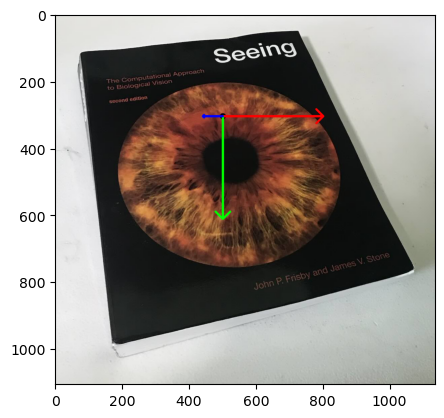

In [94]:
# Read and display an image (this is just an example image)
img = cv2.imread('stone.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw the 3D coordinate frame
draw_coordinate_frame(image_points, img)